In [1]:
### Create pendulum system


# Import necessary python modules
import math
from math import pi
import numpy as np
from numpy import dot
import trep
import trep.discopt
from trep import tx, ty, tz, rx, ry, rz
import pylab

# Build a pendulum system
m = 1.0 # Mass of pendulum
l = 1.0 # Length of pendulum
q0 = 3./4.*pi # Initial configuration of pendulum
t0 = 0.0 # Initial time
tf = 5.0 # Final time
dt = 0.1 # Sampling time
qBar = pi # Desired configuration
Q = np.eye(2) # Cost weights for states
R = np.eye(1) # Cost weights for inputs

system = trep.System() # Initialize system

frames = [
    rx('theta', name="pendulumShoulder"), [
        tz(-l, name="pendulumArm", mass=m)]]
system.import_frames(frames) # Add frames

# Add forces to the system
trep.potentials.Gravity(system, (0, 0, -9.8)) # Add gravity
trep.forces.Damping(system, 1.0) # Add damping
trep.forces.ConfigForce(system, 'theta', 'theta-torque') # Add input

# Create and initialize the variational integrator
mvi = trep.MidpointVI(system)
mvi.initialize_from_configs(t0, np.array([q0]), t0+dt, np.array([q0]))

In [2]:
### Create discrete system


TVec = np.arange(t0, tf+dt, dt) # Initialize discrete time vector
dsys = trep.discopt.DSystem(mvi, TVec) # Initialize discrete system
xBar = dsys.build_state(qBar) # Create desired state configuration

In [3]:
### Design linear feedback controller


Qd = np.zeros((len(TVec), dsys.system.nQ)) # Initialize desired configuration trajectory
thetaIndex = dsys.system.get_config('theta').index # Find index of theta config variable
for i,t in enumerate(TVec):
    Qd[i, thetaIndex] = qBar # Set desired configuration trajectory
    (Xd, Ud) = dsys.build_trajectory(Qd) # Set desired state and input trajectory

Qk = lambda k: Q # Create lambda function for state cost weights
Rk = lambda k: R # Create lambda function for input cost weights
KVec = dsys.calc_feedback_controller(Xd, Ud, Qk, Rk) # Solve for linear feedback controller gain
KStabilize = KVec[0] # Use only use first value to approximate infinite-horizon optimal controller gain

# Reset discrete system state
dsys.set(np.array([q0, 0.]), np.array([0.]), 0)

In [4]:
### Simulate the system forward


T = [mvi.t1] # List to hold time values
Q = [mvi.q1] # List to hold configuration values
X = [dsys.xk] # List to hold state values
U = [] # List to hold input values
while mvi.t1 < tf-dt:
    x = dsys.xk # Grab current state
    xTilde = x - xBar # Compare to desired state
    u = -dot(KStabilize, xTilde) # Calculate input
    dsys.step(u) # Step the system forward by one time step
    T.append(mvi.t1) # Update lists
    Q.append(mvi.q1)
    X.append(x)
    U.append(u)

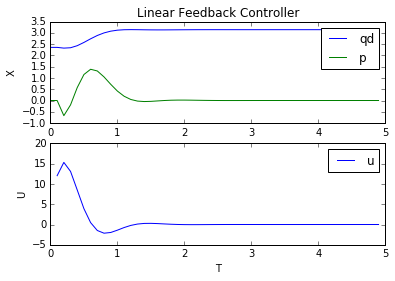

In [5]:
### Visualize the system in action


trep.visual.visualize_3d([ trep.visual.VisualItem3D(system, T, Q) ])

# Plot results
ax1 = pylab.subplot(211)
pylab.plot(T, X)
pylab.title("Linear Feedback Controller")
pylab.ylabel("X")
pylab.legend(["qd","p"])
pylab.subplot(212, sharex=ax1)
pylab.plot(T[1:], U)
pylab.xlabel("T")
pylab.ylabel("U")
pylab.legend(["u"])
pylab.show()